In [1]:
# CELL 1: Mount Google Drive (with retry)
from google.colab import drive
import os

# Force unmount if previously mounted
try:
    drive.flush_and_unmount()
except:
    pass

# Mount with force_remount
drive.mount('/content/drive', force_remount=True)

# Create project directory in Drive
project_dir = '/content/drive/MyDrive/SDN_Model'
os.makedirs(project_dir, exist_ok=True)
os.chdir(project_dir)

print(f"✓ Working directory: {os.getcwd()}")


Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive
✓ Working directory: /content/drive/MyDrive/SDN_Model


In [3]:
# CELL 2: Load InSDN Dataset from Drive
import pandas as pd
import numpy as np

df = pd.read_csv('/content/drive/MyDrive/SDN_Model/InSDN.csv')

print(f"Total dataset shape: {df.shape}")
print(f"\nColumn names:")
print(df.columns.tolist())
print(f"\nLabel distribution:")
print(df['Label'].value_counts())



Total dataset shape: (343889, 84)

Column names:
['Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Protocol', 'Timestamp', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt', 'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg', 'Fwd Seg Si

In [4]:
# Cell 1: Install libraries (run once per runtime)
!pip install xgboost --quiet

import pandas as pd
import numpy as np
import os
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

from xgboost import XGBClassifier


In [5]:
DATA_PATH = "/content/drive/MyDrive/SDN_Model/InSDN.csv"
SAVE_DIR = "/content/drive/MyDrive/SDN_Model/"

os.makedirs(SAVE_DIR, exist_ok=True)
print("Saving models to:", SAVE_DIR)

Saving models to: /content/drive/MyDrive/SDN_Model/


In [6]:
# Cell 3: Load the InSDN dataset
df = pd.read_csv(DATA_PATH)

print("Total dataset shape:", df.shape)
print("\nColumns:")
print(df.columns.tolist())

print("\nLabel distribution:")
print(df['Label'].value_counts())


Total dataset shape: (343889, 84)

Columns:
['Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Protocol', 'Timestamp', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt', 'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg', 'Fwd Seg Size Av

In [7]:
# Cell 4: Clean labels and drop ID-like columns

# Strip whitespace from labels (just in case)
df['Label'] = df['Label'].astype(str).str.strip()

print("Unique labels after strip():")
print(df['Label'].value_counts())

# Binary label: Normal = 0, anything else = 1
df['BinaryLabel'] = (df['Label'] != 'Normal').astype(int)

print("\nBinary label distribution (0=Normal, 1=Attack):")
print(df['BinaryLabel'].value_counts())

# Columns to drop (ID/address/timestamps that don't generalize)
cols_to_drop = [
    'Flow ID', 'Src IP', 'Dst IP', 'Timestamp'
]

# Some versions may not have exactly these columns; keep only existing
cols_to_drop = [c for c in cols_to_drop if c in df.columns]

df = df.drop(columns=cols_to_drop)
print("\nRemaining columns after dropping ID/meta:", len(df.columns))


Unique labels after strip():
Label
DDoS          121942
Probe          98129
Normal         68424
DoS            53616
BFA             1405
Web-Attack       192
BOTNET           164
U2R               17
Name: count, dtype: int64

Binary label distribution (0=Normal, 1=Attack):
BinaryLabel
1    275465
0     68424
Name: count, dtype: int64

Remaining columns after dropping ID/meta: 81


In [8]:
# Cell 5: Handle infinities and NaNs

before_rows = len(df)

df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with any NaN (you can change to imputation if you prefer)
df.dropna(inplace=True)

after_rows = len(df)
print(f"Dropped {before_rows - after_rows} rows with NaN/inf values.")
print("New shape:", df.shape)


Dropped 0 rows with NaN/inf values.
New shape: (343889, 81)


In [9]:
# Cell 6: Split into features (X) and target (y), then train/val/test

target_col = 'BinaryLabel'

# Use all columns except Label (multi-class) and BinaryLabel as features
feature_cols = [c for c in df.columns if c not in ['Label', 'BinaryLabel']]

X = df[feature_cols].astype(float)
y = df[target_col].astype(int)

print("Features shape:", X.shape)
print("Target shape:", y.shape)

# First split: train (70%), temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.30,
    random_state=42,
    stratify=y
)

# Second split: validation (15%), test (15%) from temp
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    random_state=42,
    stratify=y_temp
)

print("\nTrain shape:", X_train.shape, "Label dist:", np.bincount(y_train))
print("Val shape:",   X_val.shape,   "Label dist:", np.bincount(y_val))
print("Test shape:",  X_test.shape,  "Label dist:", np.bincount(y_test))


Features shape: (343889, 79)
Target shape: (343889,)

Train shape: (240722, 79) Label dist: [ 47897 192825]
Val shape: (51583, 79) Label dist: [10263 41320]
Test shape: (51584, 79) Label dist: [10264 41320]


In [10]:
# Cell 7: Scale features using StandardScaler (fit on train only)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

print("Scaling done. Example of first scaled train row:")
print(X_train_scaled[0][:10])  # first 10 features as a peek


Scaling done. Example of first scaled train row:
[ 0.66799222  0.08710223  0.212408   -0.30770339 -0.07305186 -0.04627053
 -0.016876   -0.02849032 -0.17213663 -0.1406779 ]


In [11]:
# Cell 8: Define XGBoost model

# Compute class imbalance weight: pos_weight = (neg / pos)
neg_count = (y_train == 0).sum()
pos_count = (y_train == 1).sum()
scale_pos_weight = neg_count / pos_count

print("Negatives (0):", neg_count)
print("Positives (1):", pos_count)
print("scale_pos_weight:", scale_pos_weight)

xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,
    n_jobs=-1,
    random_state=42,
    tree_method='hist'  # faster, good for larger datasets
)

xgb_model


Negatives (0): 47897
Positives (1): 192825
scale_pos_weight: 0.24839621418384544


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=-1,
              num_parallel_tree=None, ...)

In [15]:
# Cell 9 (final): Train XGBoost without early stopping

eval_set = [(X_train_scaled, y_train), (X_val_scaled, y_val)]

xgb_model.fit(
    X_train_scaled,
    y_train,
    eval_set=eval_set,
    verbose=False  # set True if you want to see training progress
)

print("Training completed.")


Training completed.



=== XGBoost – Validation Set ===
Accuracy: 0.9999806137681019
Precision: 1.0
Recall: 0.9999757986447241
F1: 0.9999878991759339
ROC-AUC: 0.9999999811350636

Classification report (val):
              precision    recall  f1-score   support

           0     0.9999    1.0000    1.0000     10263
           1     1.0000    1.0000    1.0000     41320

    accuracy                         1.0000     51583
   macro avg     1.0000    1.0000    1.0000     51583
weighted avg     1.0000    1.0000    1.0000     51583



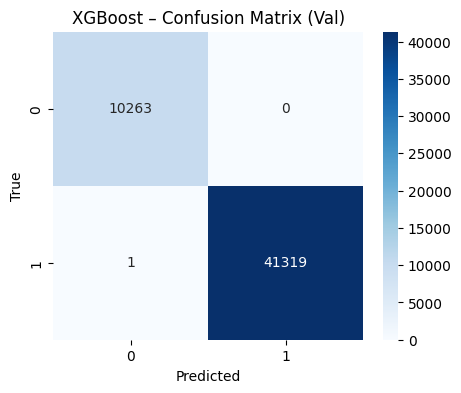


=== XGBoost – Test Set ===
Accuracy: 0.9999030707196029
Precision: 0.9999032016068533
Recall: 0.9999757986447241
F1: 0.9999394988081265
ROC-AUC: 0.9999974888500226

Classification report (test):
              precision    recall  f1-score   support

           0     0.9999    0.9996    0.9998     10264
           1     0.9999    1.0000    0.9999     41320

    accuracy                         0.9999     51584
   macro avg     0.9999    0.9998    0.9998     51584
weighted avg     0.9999    0.9999    0.9999     51584



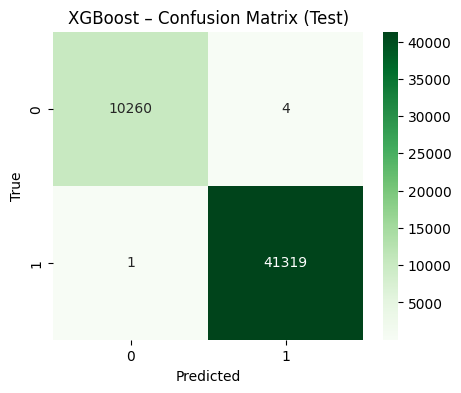

In [16]:
# Cell 10: Evaluation (validation & test sets)

def evaluate_model(model, X_tr, y_tr, X_v, y_v, X_te, y_te, name="Model"):
    print(f"\n=== {name} – Validation Set ===")
    y_val_pred = model.predict(X_v)
    y_val_proba = model.predict_proba(X_v)[:, 1]

    print("Accuracy:", accuracy_score(y_v, y_val_pred))
    print("Precision:", precision_score(y_v, y_val_pred))
    print("Recall:", recall_score(y_v, y_val_pred))
    print("F1:", f1_score(y_v, y_val_pred))
    print("ROC-AUC:", roc_auc_score(y_v, y_val_proba))
    print("\nClassification report (val):")
    print(classification_report(y_v, y_val_pred, digits=4))

    cm_val = confusion_matrix(y_v, y_val_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} – Confusion Matrix (Val)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    print(f"\n=== {name} – Test Set ===")
    y_test_pred = model.predict(X_te)
    y_test_proba = model.predict_proba(X_te)[:, 1]

    print("Accuracy:", accuracy_score(y_te, y_test_pred))
    print("Precision:", precision_score(y_te, y_test_pred))
    print("Recall:", recall_score(y_te, y_test_pred))
    print("F1:", f1_score(y_te, y_test_pred))
    print("ROC-AUC:", roc_auc_score(y_te, y_test_proba))
    print("\nClassification report (test):")
    print(classification_report(y_te, y_test_pred, digits=4))

    cm_test = confusion_matrix(y_te, y_test_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens')
    plt.title(f'{name} – Confusion Matrix (Test)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

evaluate_model(
    xgb_model,
    X_train_scaled, y_train,
    X_val_scaled, y_val,
    X_test_scaled, y_test,
    name="XGBoost"
)


In [17]:
# Cell 11: Stratified 3-fold cross-validation on train set (optional)

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

cv_scores = cross_val_score(
    xgb_model,
    X_train_scaled,
    y_train,
    cv=skf,
    scoring='roc_auc',
    n_jobs=-1
)

print("Cross-validated ROC-AUC scores:", cv_scores)
print("Mean ROC-AUC:", cv_scores.mean(), "+/-", cv_scores.std())


Cross-validated ROC-AUC scores: [1.         0.99999864 0.99999875]
Mean ROC-AUC: 0.9999991283238963 +/- 6.181355920579563e-07


Top 20 features:
Pkt Size Avg         0.390851
Pkt Len Max          0.225395
Pkt Len Mean         0.108266
SYN Flag Cnt         0.054880
Bwd IAT Tot          0.043958
Init Bwd Win Byts    0.036881
Dst Port             0.012537
Bwd Header Len       0.012322
Fwd Pkt Len Min      0.011577
Tot Bwd Pkts         0.010418
Bwd IAT Max          0.010236
Fwd Pkt Len Max      0.009130
TotLen Fwd Pkts      0.007596
Fwd Pkt Len Mean     0.005664
Tot Fwd Pkts         0.004350
Fwd Header Len       0.004220
Idle Mean            0.004113
Pkt Len Min          0.003676
RST Flag Cnt         0.003225
ACK Flag Cnt         0.002544
dtype: float32


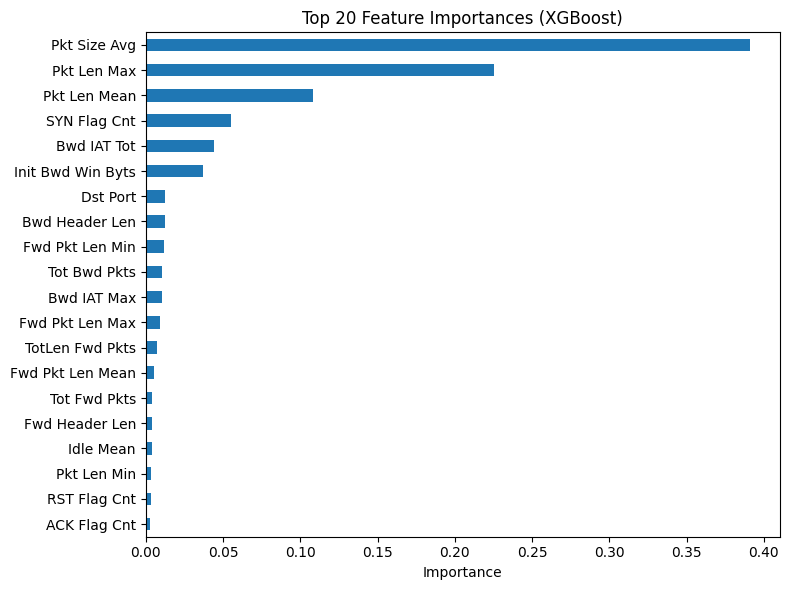


Top 12 selected features:
- Pkt Size Avg
- Pkt Len Max
- Pkt Len Mean
- SYN Flag Cnt
- Bwd IAT Tot
- Init Bwd Win Byts
- Dst Port
- Bwd Header Len
- Fwd Pkt Len Min
- Tot Bwd Pkts
- Bwd IAT Max
- Fwd Pkt Len Max


In [18]:
# Cell 12: Feature importance and top-k selection

importances = xgb_model.feature_importances_
feat_importances = pd.Series(importances, index=feature_cols)

# Sort
feat_importances_sorted = feat_importances.sort_values(ascending=False)

print("Top 20 features:")
print(feat_importances_sorted.head(20))

# Plot top 20
plt.figure(figsize=(8,6))
feat_importances_sorted.head(20).plot(kind='barh')
plt.gca().invert_yaxis()
plt.title('Top 20 Feature Importances (XGBoost)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

# Choose K most important features (adjust K to what you want, e.g. 12)
TOP_K = 12
top_k_features = feat_importances_sorted.head(TOP_K).index.tolist()

print(f"\nTop {TOP_K} selected features:")
for f in top_k_features:
    print("-", f)



=== XGBoost Top-12 – Validation Set ===
Accuracy: 0.9999224550724076
Precision: 0.9999515972894482
Recall: 0.9999515972894482
F1: 0.9999515972894482
ROC-AUC: 0.9999998148878116

Classification report (val):
              precision    recall  f1-score   support

           0     0.9998    0.9998    0.9998     10263
           1     1.0000    1.0000    1.0000     41320

    accuracy                         0.9999     51583
   macro avg     0.9999    0.9999    0.9999     51583
weighted avg     0.9999    0.9999    0.9999     51583



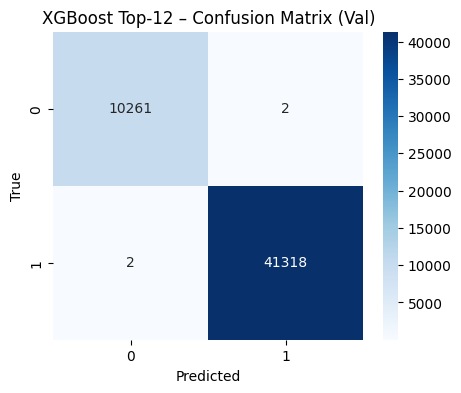


=== XGBoost Top-12 – Test Set ===
Accuracy: 0.9998642990074442
Precision: 0.999927394177013
Recall: 0.9999031945788964
F1: 0.9999152942315371
ROC-AUC: 0.9999974735237551

Classification report (test):
              precision    recall  f1-score   support

           0     0.9996    0.9997    0.9997     10264
           1     0.9999    0.9999    0.9999     41320

    accuracy                         0.9999     51584
   macro avg     0.9998    0.9998    0.9998     51584
weighted avg     0.9999    0.9999    0.9999     51584



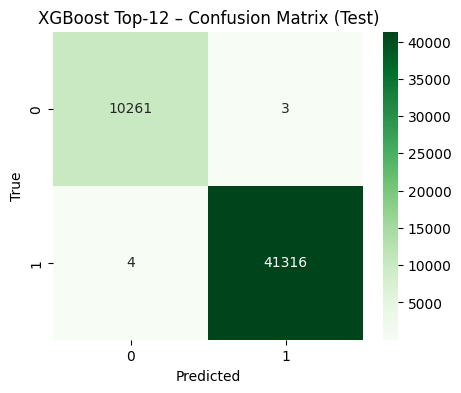

In [20]:
# Cell 13: Retrain model on top-k features only

X_topk = df[top_k_features]
y_binary = df['BinaryLabel'].astype(int)

X_train_k, X_temp_k, y_train_k, y_temp_k = train_test_split(
    X_topk, y_binary,
    test_size=0.30,
    random_state=42,
    stratify=y_binary
)

X_val_k, X_test_k, y_val_k, y_test_k = train_test_split(
    X_temp_k, y_temp_k,
    test_size=0.50,
    random_state=42,
    stratify=y_temp_k
)

# Scale again for the reduced feature set
scaler_k = StandardScaler()
X_train_k_scaled = scaler_k.fit_transform(X_train_k)
X_val_k_scaled   = scaler_k.transform(X_val_k)
X_test_k_scaled  = scaler_k.transform(X_test_k)

# Recompute class imbalance for this split (should be similar)
neg_k = (y_train_k == 0).sum()
pos_k = (y_train_k == 1).sum()
scale_pos_weight_k = neg_k / pos_k

xgb_topk = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight_k,
    n_jobs=-1,
    random_state=42,
    tree_method='hist'
)

eval_set_k = [(X_train_k_scaled, y_train_k), (X_val_k_scaled, y_val_k)]

xgb_topk.fit(
    X_train_k_scaled,
    y_train_k,
    eval_set=eval_set_k,
    verbose=False,
)

evaluate_model(
    xgb_topk,
    X_train_k_scaled, y_train_k,
    X_val_k_scaled, y_val_k,
    X_test_k_scaled, y_test_k,
    name=f"XGBoost Top-{TOP_K}"
)


In [21]:
# Cell 14: Save models, scalers, and feature name lists

full_model_path      = os.path.join(SAVE_DIR, "xgb_full.pkl")
full_scaler_path     = os.path.join(SAVE_DIR, "scaler_full.pkl")
full_features_path   = os.path.join(SAVE_DIR, "feature_names_full.pkl")

topk_model_path      = os.path.join(SAVE_DIR, "xgb_topk.pkl")
topk_scaler_path     = os.path.join(SAVE_DIR, "scaler_topk.pkl")
topk_features_path   = os.path.join(SAVE_DIR, "feature_names_topk.pkl")

# Save full model artifacts
joblib.dump(xgb_model, full_model_path)
joblib.dump(scaler, full_scaler_path)
joblib.dump(feature_cols, full_features_path)

# Save top-k model artifacts
joblib.dump(xgb_topk, topk_model_path)
joblib.dump(scaler_k, topk_scaler_path)
joblib.dump(top_k_features, topk_features_path)

print("Saved:")
print(" -", full_model_path)
print(" -", full_scaler_path)
print(" -", full_features_path)
print(" -", topk_model_path)
print(" -", topk_scaler_path)
print(" -", topk_features_path)


Saved:
 - /content/drive/MyDrive/SDN_Model/xgb_full.pkl
 - /content/drive/MyDrive/SDN_Model/scaler_full.pkl
 - /content/drive/MyDrive/SDN_Model/feature_names_full.pkl
 - /content/drive/MyDrive/SDN_Model/xgb_topk.pkl
 - /content/drive/MyDrive/SDN_Model/scaler_topk.pkl
 - /content/drive/MyDrive/SDN_Model/feature_names_topk.pkl
